### The majority of this notebook's content can also be found in the 'time_frequency_map' notebook, with some possible differences.

In [1]:
import sys
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import welch
from fooof import FOOOF, Bands, FOOOFGroup

sys.path.append('D:/capachinos')

C:\Users\Kourosh\AppData\Local\Temp\ipykernel_13904\1843196007.py:5: DeprecationWarning: 
The `fooof` package is being deprecated and replaced by the `specparam` (spectral parameterization) package.
This version of `fooof` (1.1) is fully functional, but will not be further updated.
New projects are recommended to update to using `specparam` (see Changelog for details).
  from fooof import FOOOF, Bands, FOOOFGroup


In [2]:
from src.eeg_analysis.preprocessing.eeg_file import EEGFile
from src.eeg_analysis.preprocessing.eeg_preprocessor import EEGPreprocessor
from src.eeg_analysis.analysis.power_spectral import PowerSpectralAnalysis, TimeFrequencyRepresentation
from src.eeg_analysis.visualization.plots import plot_continuous_epochs

participant_id = 1
vhdr_path = r'D:\Anesthesia_Research_Fellow\CA-01\CA-01.vhdr'
vmrk_path = r'D:\Anesthesia_Research_Fellow\CA-01\CA-01.vmrk'
eeg_path = r'D:\Anesthesia_Research_Fellow\CA-01\CA-01.eeg'

eeg_file = EEGFile(participant_id, vhdr_path, vmrk_path, eeg_path)
eeg_file.load_data()

In [3]:
preprocessor = EEGPreprocessor(eeg_file)

target_fs = 250
window_size = 10
step_size = 5
order = 5
low_cutoff = 0.5
high_cutoff = 55
epoch_length = 30

sequence_of_operations = [
    ('downsample', {'target_fs': target_fs}),
    ('create_epochs', {'events_df': eeg_file.events_df}),
    # ('detrend', {'window_size': window_size, 'step_size': step_size}),
    # ('re_reference', {'reference_type': 'average'}),
    ('bandpass_filter', {'order': order,'low_cutoff': low_cutoff, 'high_cutoff': high_cutoff}),
    ('exclude_noisy_periods', {'window_size':2, 'threshold':2, 'min_num_channels':4, 'padding':'zeros'})
]
preprocessor.process(sequence_of_operations)

In [4]:
power_spectral = PowerSpectralAnalysis(preprocessor, window_size=2, step_size=1)

In [5]:
power_spectral.calculate_time_frequency_map(select_channels = None, select_epochs=['pre_drug_infusion', 'emergence'], method='morlet')

NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


In [6]:
power_spectral.postprocess_anatomical_region_average()

In [7]:
power_spectral.postprocess_time_window_average(window_size=300, step_size=100, attr_name='region_average_tfr')

In [8]:
power_spectral.window_average_tfr['prefrontal']['emergence'].times

array([ 150.,  250.,  350.,  450.,  550.,  650.,  750.,  850.,  950.,
       1050., 1150., 1250., 1350., 1450., 1550., 1650., 1750., 1850.,
       1950., 2050., 2150., 2250., 2350., 2450., 2550., 2650., 2750.,
       2850., 2950., 3050., 3150., 3250., 3350., 3450., 3550., 3650.,
       3750., 3850.])

In [9]:
power_spectral.postprocess_aperiodic_paramaters(attr_name='window_average_tfr')

In [10]:
power_spectral.postprocess_periodic_parameters(attr_name='window_average_tfr', peak_threshold= 1.5, overlap_threshold=0.5)

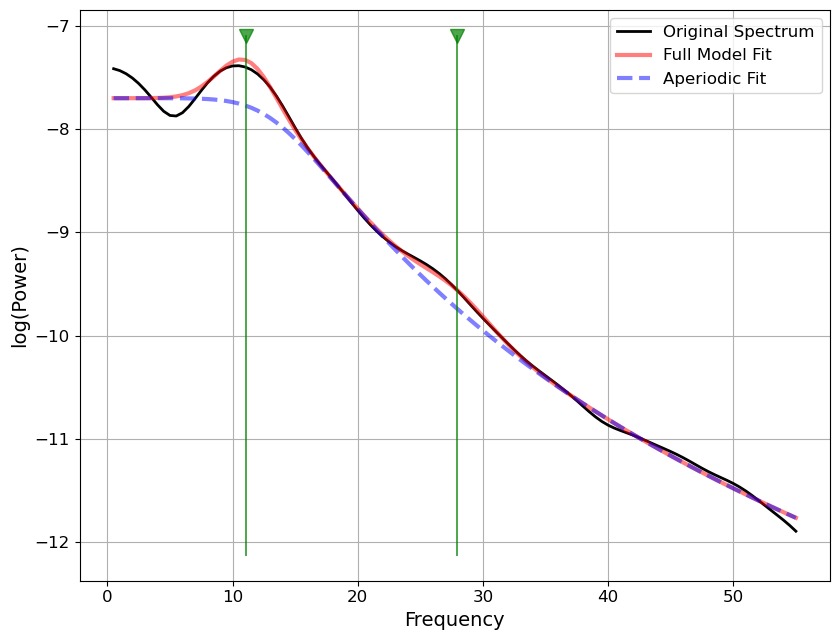

In [26]:
power_spectral.fooof_models['prefrontal']['emergence'][0, 0].plot(plt_log=False, plot_peaks='line')

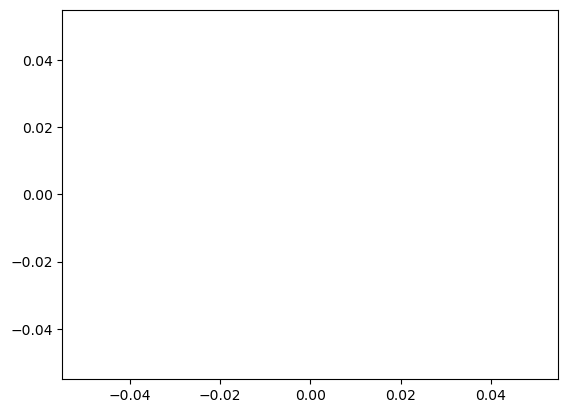

In [18]:
plt.figure()

plt.plot(power_spectral.fooof_periodic_parameters['prefrontal']['emergence']['delta']['cf'][0])
# plt.ylim([6,7])


In [ ]:
power_spectral.fooof_aperiodic_parameters['temporal']['emergence']['exponents'][0]

In [ ]:
epoch_name = 'emergence'
tfr = power_spectral.tfr[epoch_name]
tfr_data = power_spectral.region_average_tfr['prefrontal'][epoch_name].data
time_points = tfr.times
# tfr.data = tfr.data[:, :len(time_points)]

segments = np.arange(time_points[0], time_points[-1], 300)
num_segments = len(segments)-1

psds = np.full((len(tfr.frequencies), num_segments), np.nan)
stds = np.full((len(tfr.frequencies), num_segments), np.nan)

for seg_idx in range(num_segments):
    seg_time_idx = (tfr.times >= segments[seg_idx]) & (tfr.times < segments[seg_idx+1])
    psds[:, seg_idx], stds[:, seg_idx] = TimeFrequencyRepresentation._calculate_mean_spectral_power_with_outlier_removal(tfr_data[:, seg_time_idx, np.newaxis])

In [ ]:
freqs = tfr.frequencies

# freq_range = [2, 55]

freq_range = [20, 40]

# Variables for subplots - 6 segments per row, 2 plots per segment (PSD and FOOOF)
segments_per_row = 6
num_rows = 2 * num_segments // segments_per_row + (2 if num_segments % segments_per_row else 0)

# Create figure and subplots
fig, axes = plt.subplots(num_rows, segments_per_row, figsize=(segments_per_row * 5, num_rows * 5))
plt.subplots_adjust(hspace=0.6)

# Flatten the axes array for easier indexing
axes_flat = axes.flatten()
fm_over_time = []

# Iterate through segments and plot
for seg_idx in range(num_segments):
    
    row_idx_top = 2 * seg_idx  # Note the change here, double the seg_idx to get the top row

    
    # Plot for PSD and Std
    ax_psd = axes_flat[row_idx_top]
    
    # Convert the power to decibels
    psd_db = 10 * np.log10(psds[:, seg_idx])
    std_db = 10 * np.log10(psds[:, seg_idx] + stds[:, seg_idx]) - psd_db

    # Plot the mean and standard deviation of spectral power for the current segment
    ax_psd.plot(freqs, psd_db, label=f'Segment {seg_idx+1}')
    ax_psd.fill_between(freqs, psd_db - std_db, psd_db + std_db, alpha=0.2)
    # ax_psd.set_xscale('log')


    ax_psd.set_xlim(freq_range)
    ax_psd.set_title(f'Segment {seg_idx} - PSD')
    ax_psd.legend()

    # Plot for FOOOF fit results
    ax_fooof = axes_flat[row_idx_top + 1]
    
    # Fit the FOOOF model
    fm = FOOOF(aperiodic_mode='fixed', peak_threshold=2, verbose=False) # aperiodic_mode:{'fixed', 'knee'}
    fm.fit(freqs, psds[:, seg_idx], freq_range) 
    
    # Plot the FOOOF model results
    fm.plot(ax=ax_fooof, plt_log=False, plot_peaks='line') #'shade', 'dot', 'line', 'outline'
    ax_fooof.set_title(f'Segment {seg_idx} - FOOOF')
    # ax_fooof.set_xlim(freq_range)

    # Set x-axis labels if using the last row
    # if row_idx_top + 1 == num_rows - 1 or (row_idx_top + 2 == num_rows - 1 and col_idx == num_segments % segments_per_row - 1):
    #     ax_psd.set_xlabel('Frequency (Hz)')
    #     ax_fooof.set_xlabel('Frequency (Hz)')

    # if seg_idx == 0:
    #     fm_example = fm.copy()
    fm_over_time.append(fm)


# Hide any unused subplots
for unused_ax in axes_flat[2 * num_segments:]:
    unused_ax.set_visible(False) # set unused subplots as invisible

plt.tight_layout()
plt.show()

In [ ]:
exponent = np.full((num_segments,), np.nan)
intercept = np.full((num_segments,), np.nan)
first_peak = np.full((num_segments,), np.nan)
# first_peak_relative_height = np.full((num_segments,), np.nan)
# first_peak_bw = np.full((num_segments,), np.nan)

second_peak = np.full((num_segments,), np.nan)
# second_peak_relative_height = np.full((num_segments,), np.nan)
# second_peak_bw = np.full((num_segments,), np.nan)


for seg_idx in range(num_segments):
    intercept[seg_idx] = fm_over_time[seg_idx].aperiodic_params_[0]
    exponent[seg_idx] = fm_over_time[seg_idx].aperiodic_params_[1]

    peaks = fm_over_time[seg_idx].peak_params_
    first_peak[seg_idx] = peaks[0][0]
    # first_peak_relative_height[seg_idx] = peaks[0][1]
    # first_peak_bw[seg_idx] = peaks[0][2]

    second_peak[seg_idx] = peaks[1][0]
    # second_peak_relative_height[seg_idx] = peaks[1][1]
    # second_peak_bw[seg_idx] = peaks[1][2]

    # if peaks.shape[0] > 1:
    #     second_peak[seg_idx] = peaks[1][0]
    
plt.figure(figsize=(7,7))
plt.plot(first_peak)
plt.ylim([np.percentile(first_peak, 5), np.percentile(first_peak, 95)]) # only for exponent

##### Group FOOOF

In [ ]:
bands2 = Bands({'alpha' : [7, 14],
                'beta' : [18, 35],
                'gamma': [40, 55]})
freq_range = [20, 40]
# Fit the FOOOF model
fm = FOOOFGroup(aperiodic_mode='knee', peak_threshold=2, verbose=False) # aperiodic_mode:{'fixed', 'knee'}
fm.fit(freqs, psds.T, freq_range) 
temp = fm.to_df(bands2)

# plt.plot(temp['alpha_cf'])
plt.plot(temp['exponent'])
plt.ylim([6, 7])

In [ ]:
aa = fm.get_results()
bb=aa[0]
bb[0]
print(aa)
print(bb[0])

In [ ]:
temp['knee'].values

##### Periodic components

In [ ]:
from fooof.plts.spectra import plot_spectra
plot_spectra(fm_over_time[1].freqs, fm_over_time[1].get_data('peak'), color='black')

In [ ]:
plot_spectra(fm_over_time[1].freqs, [fm_over_time[1].get_data('peak'), fm_over_time[1].get_model('peak')],
             colors=['black', 'green'], linestyle=['-', '--'])